## Incremental learning with River

In [189]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from river import metrics
import sys
from util import *
from scipy.stats import mode
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import random
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
import random
from river import anomaly
from sklearn.preprocessing import StandardScaler
from predict import binarize
import os

In [2]:
X_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_train.npy")
labels_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_train.npy")
X_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_test.npy")
labels_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_test.npy")

In [15]:
X_train.shape, \
X_test.shape

((544, 906), (68, 906))

In [4]:
subset_indices =  [  191, 374,  328,  673]

### Recreate original dataset

In [5]:
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 612/17 = 36, where 612 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices_temp = np.array(random.sample(range(nbr_splits), test_split))
    test_indices = np.append(test_indices, i*nbr_splits + test_indices_temp)
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices_temp]))

print(len(train_indices))

544


In [6]:
train_ctr = 0
test_ctr = 0
data_all = []
labels_all = []
for i in range(612):
    if i in train_indices:
        data_all.append(X_train[train_ctr])
        labels_all.append(labels_train[train_ctr])
        train_ctr += 1
    elif i in test_indices:
        data_all.append(X_test[test_ctr])
        labels_all.append(labels_test[test_ctr])
        test_ctr += 1

In [7]:
y_all = binarize(labels_all) # is the labels of all instances 
data_all = np.array(data_all) # are all the instances

In [111]:
random.seed(42)
np.random.seed(42)
test_size = 0.25

train_idx = np.concatenate([[i*36 + np.random.choice(36, size=int(36*(1-test_size)), replace=False)] for i in range(17)], axis=1)[0]
test_idx = np.array([j for j in range(data_all.shape[0]) if j not in train_idx])
print(train_idx[:10])
X_train_top_f = data_all[np.sort(train_idx)]
X_test_top_f = data_all[np.sort(test_idx)]

X_train_top_f = X_train_top_f[:, subset_indices]
X_test_top_f = X_test_top_f[:, subset_indices]

y_train = y_all[train_idx]
y_test  = y_all[test_idx]

X_test_top_f.shape, X_train_top_f.shape, y_test.shape, y_train.shape 

[35 13 26 30 16 31 21 12  8 17]


((153, 4), (459, 4), (153,), (459,))

In [36]:
np.where(y_train == 1)[0][0]

216

In [22]:
def plot_roc(true_y, y_prob, method_name):
    fpr, tpr, _ = roc_curve(true_y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2  # Line width
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {method_name}')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
param_grid_bcc_log = {
    'C': [0.01, 0.1, 0.2, 0.5, 10]
} # rbf by default

### Method 0: Random sampling

In [96]:
# since the budget will be exhausted before even getting to 
def simulate_selection(budget, nbr_inst):
    global y_train
    normal_sample = []
    damage_sample = []
    # get the point at which damage starts
    while len(normal_sample) == 0 or len(damage_sample) == 0:
        start_damage = np.where(y_train == 1)[0][0]
        prop_dam = random.uniform(2*(9/17)-1, 1) # centered slightly above 0.5 since there are more damaged than undamaged
        ss1 = int((1-prop_dam)*budget)
        ss2 = int(prop_dam*budget)
        if (ss1 > start_damage) or ss2 > (nbr_inst - start_damage):
            continue
        normal_sample =  np.array(random.sample(range(0, start_damage), ss1)).astype(int)
        damage_sample =  np.array(random.sample(range(start_damage, nbr_inst), ss2)).astype(int)
        
    return np.hstack((normal_sample, damage_sample))

In [103]:
def random_sampling_experiment(seed = 42):
    global param_grid_bcc_log, X_train_top_f
    dict_rnd = {}
    nbr_train = X_train_top_f.shape[0]
    for i in np.arange(24, nbr_train, 1):
        # obtain training indices and subset training data accordingly
        train_indices =  simulate_selection(i, nbr_train) #np.hstack((np.arange(10), simulate_selection(i, nbr_train))) #random.sample(range(nbr_train), i)
        data_train_rnd = X_train_top_f[train_indices, :]
        labels_rnd = y_train[train_indices]

        # find the optimal model and fit it
        log_reg = LogisticRegression(C = 10) #GridSearchCV(LogisticRegression(), param_grid_bcc_log, scoring = 'accuracy', cv = 5) GridSearch cannot be used since many splits only contain one class
        log_reg.fit(data_train_rnd, labels_rnd)
        
        # inference and scoring
        y_pred = log_reg.predict(X_test_top_f)
        y_prob = log_reg.predict_proba(X_test_top_f)[:, 1]
        
        # append scores to dictionary
        dict_rnd[i] = [y_test, y_pred, y_prob]
    return dict_rnd

In [104]:
rnd_bcc_all_exp = []    
random.seed(12)
for i in range(30):
    rnd_bcc_all_exp.append(random_sampling_experiment(seed = i))

In [105]:
import json
exp_temp = []
for exp in rnd_bcc_all_exp:
    dict_tmp = {}
    for key in exp.keys():
        dict_tmp[int(key)] = [i.tolist() for i in exp[key]] # need to convert keys to int, not int32, in order to save
    exp_temp.append(dict_tmp)

with open('rnd_bcc_all_exp_log_nogrid.json', 'w') as file:
    json.dump(exp_temp, file)

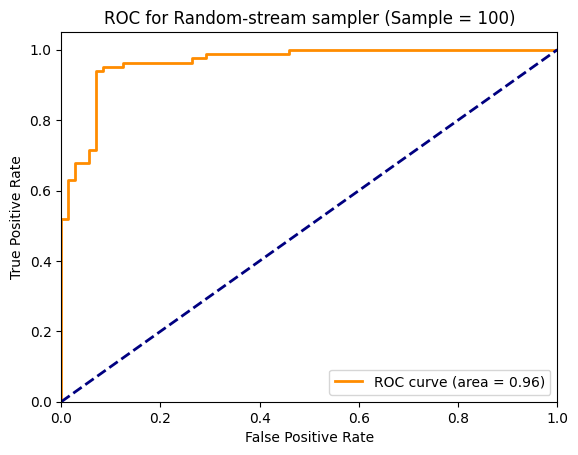

In [106]:
d_rnd = rnd_bcc_all_exp[0]
plot_roc(d_rnd[100][0], d_rnd[100][2], "Random-stream sampler (Sample = 100)")

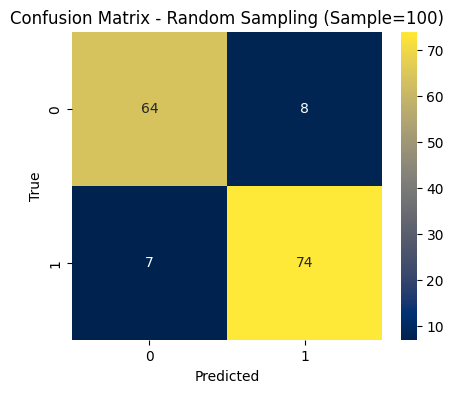

In [107]:
cms = [confusion_matrix(d_rnd[100][0], d_rnd[100][1]) for d_rnd in rnd_bcc_all_exp]
sum_conf_matrix = np.sum(cms, axis=0)
mean_conf_matrix = sum_conf_matrix / len(rnd_bcc_all_exp)
plt.figure(figsize=(5, 4))
sns.heatmap(np.around(mean_conf_matrix).astype(int), annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Random Sampling (Sample=100)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

(435,)
(435,)
(435,)
(435,)
(435,)


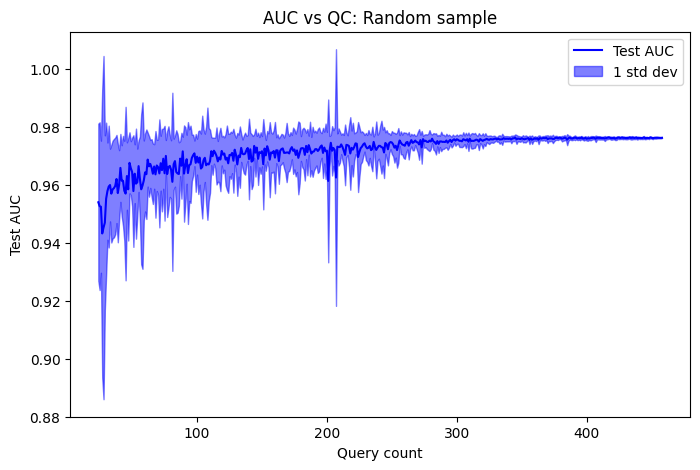

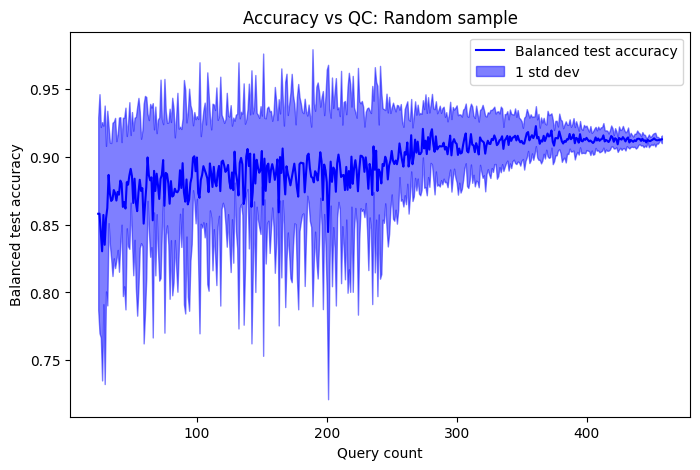

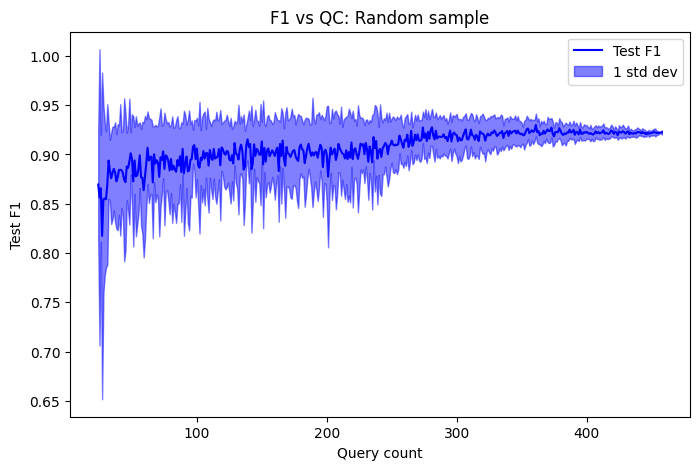

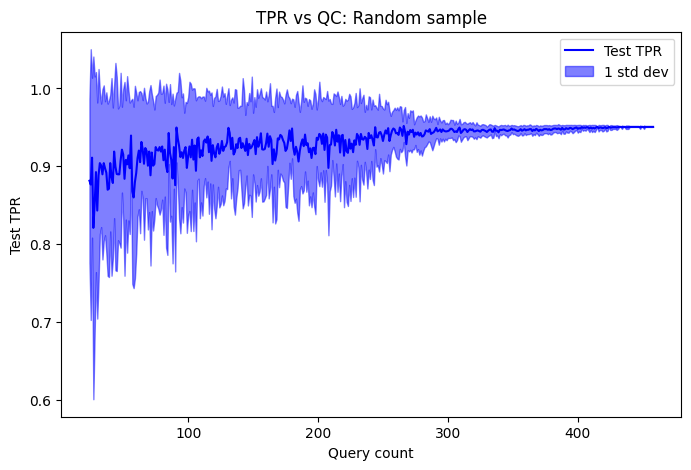

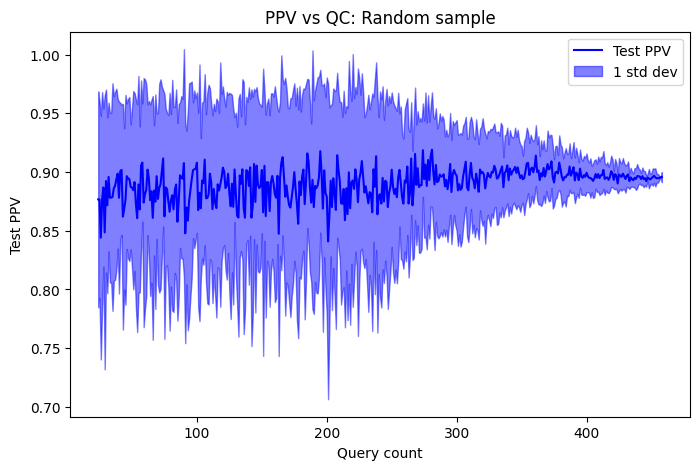

In [108]:
## f1 score 
f1_rnd = np.array(all_f1_score(range(24, X_train_top_f.shape[0]), rnd_bcc_all_exp))
avg_f1_rnd = np.mean(f1_rnd, axis = 0)
std_f1 = np.std(f1_rnd, axis = 0)
print(avg_f1_rnd.shape)

## auc 
auc_rnd = np.array(all_auc(range(24, X_train_top_f.shape[0]), rnd_bcc_all_exp))
avg_auc_rnd = np.mean(auc_rnd, axis = 0)
std_auc = np.std(auc_rnd, axis = 0)
print(avg_auc_rnd.shape)

## accuracy
acc_rnd = np.array(all_accu_score(range(24, X_train_top_f.shape[0]), rnd_bcc_all_exp))
avg_acc_rnd = np.mean(acc_rnd, axis = 0)
std_acc = np.std(acc_rnd, axis = 0)
print(avg_acc_rnd.shape)

## precision
pre_rnd = np.array(all_precision_score(range(24, X_train_top_f.shape[0]), rnd_bcc_all_exp))
avg_pre_rnd = np.mean(pre_rnd, axis = 0)
std_pre = np.std(pre_rnd, axis = 0)
print(avg_pre_rnd.shape)

## recall
rec_rnd = np.array(all_recall_score(range(24, X_train_top_f.shape[0]), rnd_bcc_all_exp))
avg_rec_rnd = np.mean(rec_rnd, axis = 0)
std_rec = np.std(rec_rnd, axis = 0)
print(avg_rec_rnd.shape)

fill_between_plot(np.arange(24, X_train_top_f.shape[0], 1), [avg_auc_rnd], [std_auc], "Test AUC", "AUC vs QC: Random sample", "Query count")
fill_between_plot(np.arange(24, X_train_top_f.shape[0], 1), [avg_acc_rnd], [std_acc], "Balanced test accuracy", "Accuracy vs QC: Random sample", "Query count")
fill_between_plot(np.arange(24, X_train_top_f.shape[0], 1), [avg_f1_rnd], [std_f1], "Test F1", "F1 vs QC: Random sample", "Query count")
fill_between_plot(np.arange(24, X_train_top_f.shape[0], 1), [avg_rec_rnd], [std_rec], "Test TPR", "TPR vs QC: Random sample", "Query count")
fill_between_plot(np.arange(24, X_train_top_f.shape[0], 1), [avg_pre_rnd], [std_pre], "Test PPV", "PPV vs QC: Random sample", "Query count")

### Method 1: Entropy-sampling 

In [150]:
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics
import re

def testing_model_entropy_sampling(model, X_test_top_f):
    global y_test

    X_river_test = [
        {f"feature_{i}": value for i, value in enumerate(sample)}
        for sample in X_test_top_f
    ]
    y_river_test = y_test.tolist()  
    #metric = metrics.Accuracy()

    preds_y = []
    preds_proba_y = []
    true_y = []

    # Process each sample in the dataset
    for i in range(len(X_river_test)):
        x = X_river_test[i]
        y_true = y_river_test[i]
        y_pred_dict, _ = model.predict_proba_one(x) 
        y_pred = max(y_pred_dict, key=y_pred_dict.get)
        #metric = metric.update(y_true, y_pred)
        
        # save true label, prediction, and score of label i
        preds_y.append(y_pred)
        true_y.append(y_true)
        preds_proba_y.append(y_pred_dict[True])

    return preds_y, true_y, preds_proba_y

en_bcc_all_exp = []

# across 50 seeds
for s in range(50):
    samples_used = []
    en_exp = {}
    
    for i in range(0, 1000, 5):
        save_y = False
        # Prepare the data in a format compatible with river
        X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in X_train_top_f
        ]
        y_river = y_train.tolist() 

        metric = metrics.Accuracy()
        base_model = linear_model.LogisticRegression(l2=0.1)
        model = active.EntropySampler(base_model, discount_factor=i, seed=s)

        n_samples_used = 0

        # Process each sample in the dataset
        for j in range(len(X_river)):
            x = X_river[j]
            y_true = y_river[j]
            y_pred, ask = model.predict_one(x) 
            metric = metric.update(y_true, y_pred)

            if ask:
                n_samples_used += 1
                model = model.learn_one(x, y_true)  # Learn from the true label
                
        if len(samples_used) > 0 and (samples_used[-1] <= n_samples_used):
            continue

        samples_used.append(n_samples_used)
        preds_y, true_y, preds_proba_y = testing_model_entropy_sampling(model, X_test_top_f)
        
        en_exp[int(n_samples_used)] = [true_y, preds_y, preds_proba_y]
    en_bcc_all_exp.append(en_exp)

In [151]:
with open('en_bcc_all_exp_ordered.json', 'w') as file:
    json.dump(en_bcc_all_exp, file)

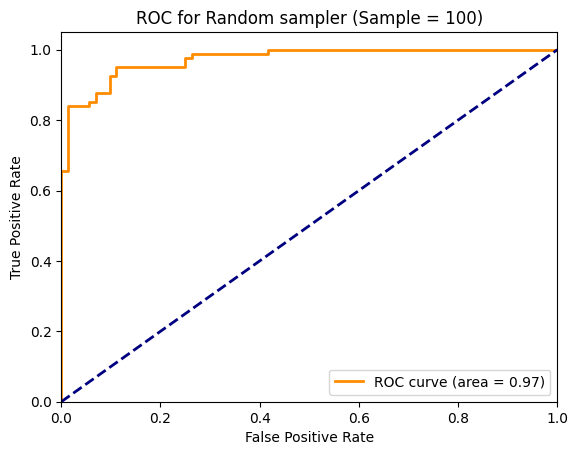

In [152]:
d_rnd = en_bcc_all_exp[0] # 0 and 1 both did not have 100 as key
plot_roc(d_rnd[100][0], d_rnd[100][2], "Random sampler (Sample = 100)") # 100 was not available for the first experiment (index 0)

In [119]:
def find_closest_key(my_dict, target_key):
    closest_key = None
    min_diff = 1000

    for key in my_dict.keys():
        diff = abs(int(key) - target_key)
        if diff < min_diff:
            min_diff = diff
            closest_key = key

    return my_dict[closest_key]

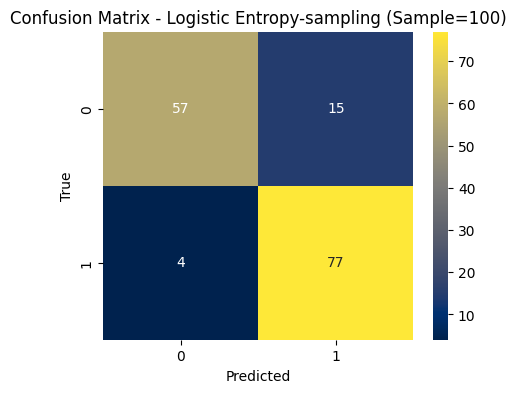

In [153]:
cms = [confusion_matrix(find_closest_key(d_rnd, 100)[0], find_closest_key(d_rnd, 100)[1]) for d_rnd in en_bcc_all_exp]
sum_conf_matrix = np.sum(cms, axis=0)
mean_conf_matrix = sum_conf_matrix / len(en_bcc_all_exp)
plt.figure(figsize=(5, 4))
sns.heatmap(np.around(mean_conf_matrix).astype(int), annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Logistic Entropy-sampling (Sample=100)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [121]:
lb = min([min(list(en_bcc_all_exp[i].keys())) for i in range(len(en_bcc_all_exp))])
ub = max([max(list(en_bcc_all_exp[i].keys())) for i in range(len(en_bcc_all_exp))])
xrange = np.arange(lb, ub)
auc_arr = []
acc_arr = []
f1_arr  = []
pre_arr = []
rec_arr = []
for exp in en_bcc_all_exp:
    skeys = sorted(exp.keys(), key=lambda x: int(x))
    xvals = []
    aucvals = []
    accvals = []
    f1vals  = []
    prevals = []
    recvals = []
    for key in skeys:
        xvals.append(key)
        truey = exp[key][0]
        predy = exp[key][1]
        proby = exp[key][2]

        # metrics
        rauc = roc_auc_score(truey, proby)
        acc = balanced_accuracy_score(truey, predy)
        f1 = f1_score(truey, predy)
        pre = precision_score(truey, predy)
        rec = recall_score(truey, predy)
        

        # append
        aucvals.append(rauc)
        accvals.append(acc)
        f1vals.append(f1)
        prevals.append(pre)
        recvals.append(rec)
    
    # interpolate and then append to the outer arrays
    f1vals = np.interp(np.arange(lb, ub), xvals, f1vals)
    accvals = np.interp(np.arange(lb, ub), xvals, accvals)
    aucvals = np.interp(np.arange(lb, ub), xvals, aucvals)
    prevals = np.interp(np.arange(lb, ub), xvals, prevals)
    recvals = np.interp(np.arange(lb, ub), xvals, recvals)
    

    auc_arr.append(aucvals)
    acc_arr.append(accvals)
    f1_arr.append(f1vals)
    pre_arr.append(prevals)
    rec_arr.append(recvals)

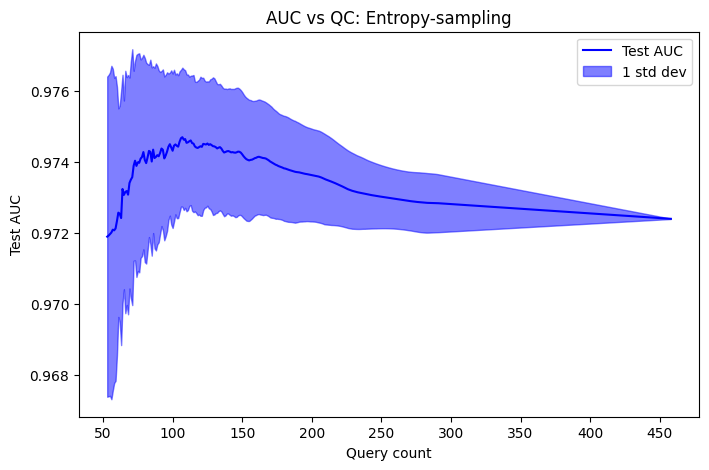

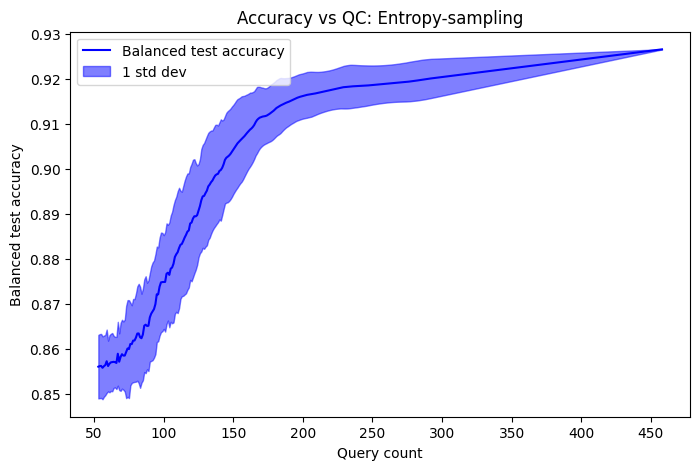

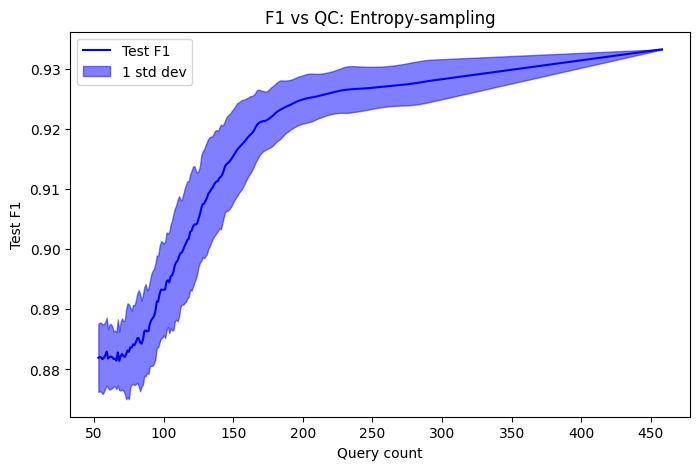

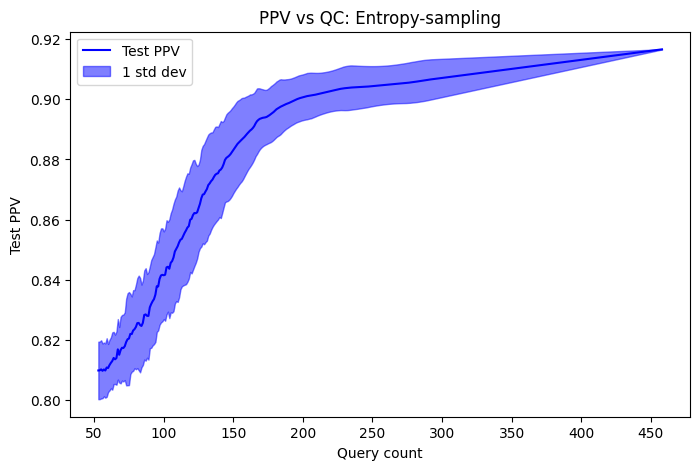

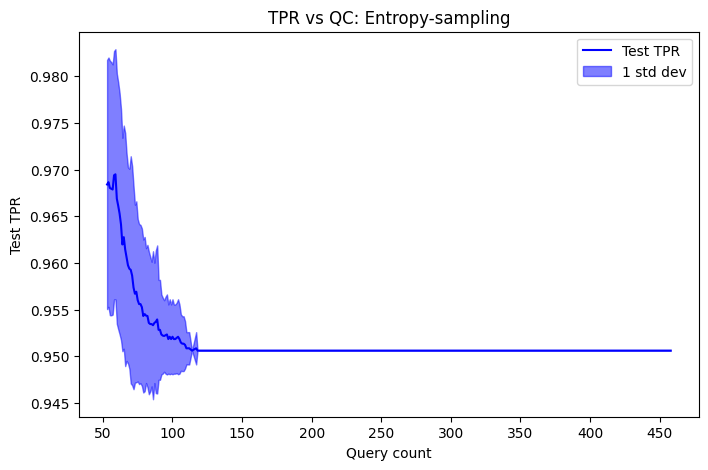

In [122]:
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(auc_arr), axis = 0)], [np.std(np.array(auc_arr), axis = 0)], "Test AUC", "AUC vs QC: Entropy-sampling", "Query count")
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(acc_arr), axis = 0)], [np.std(np.array(acc_arr), axis = 0)], "Balanced test accuracy", "Accuracy vs QC: Entropy-sampling", "Query count")
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(f1_arr), axis = 0)], [np.std(np.array(f1_arr), axis = 0)], "Test F1", "F1 vs QC: Entropy-sampling", "Query count")
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(pre_arr), axis = 0)], [np.std(np.array(pre_arr), axis = 0)], "Test PPV", "PPV vs QC: Entropy-sampling", "Query count")
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(rec_arr), axis = 0)], [np.std(np.array(rec_arr), axis = 0)], "Test TPR", "TPR vs QC: Entropy-sampling", "Query count")

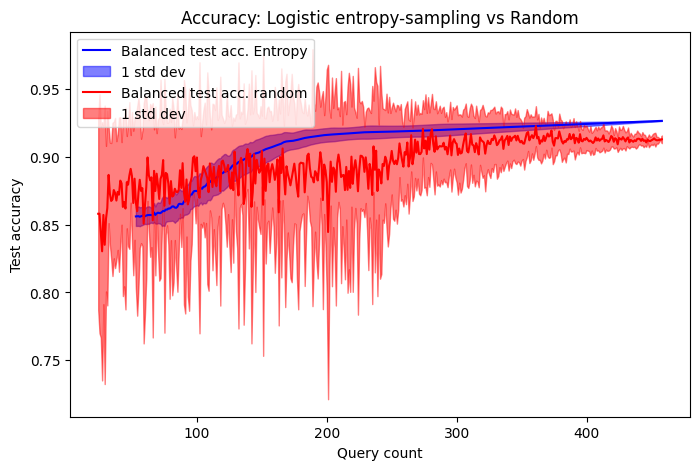

In [129]:
# Compare random and entropy
fill_between_plot_diffx([np.arange(lb, ub), np.arange(24, X_train_top_f.shape[0], 1)], [np.mean(np.array(acc_arr), axis = 0), avg_acc_rnd], [np.std(np.array(acc_arr), axis = 0), std_acc], ["Balanced test acc. Entropy", "Balanced test acc. random"], "Accuracy: Logistic entropy-sampling vs Random", "Test accuracy", "Query count")

#### Plot the entropy (~anomaly score)

In [130]:
def calculate_entropy(y_pred):
    probabilities = y_pred
    entropy = -sum(p * np.log2(p) for p in probabilities.values() if p > 0)
    return entropy

In [154]:
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in X_train_top_f
]
y_river = y_train.tolist() 

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression(l2 = 0.1)
model = active.EntropySampler(base_model, discount_factor=1, seed=42)
n_samples_used = 0
entropies = []

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_proba_one(x) 
    entropy_cur = calculate_entropy(y_pred)
    entropies.append(entropy_cur)
    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

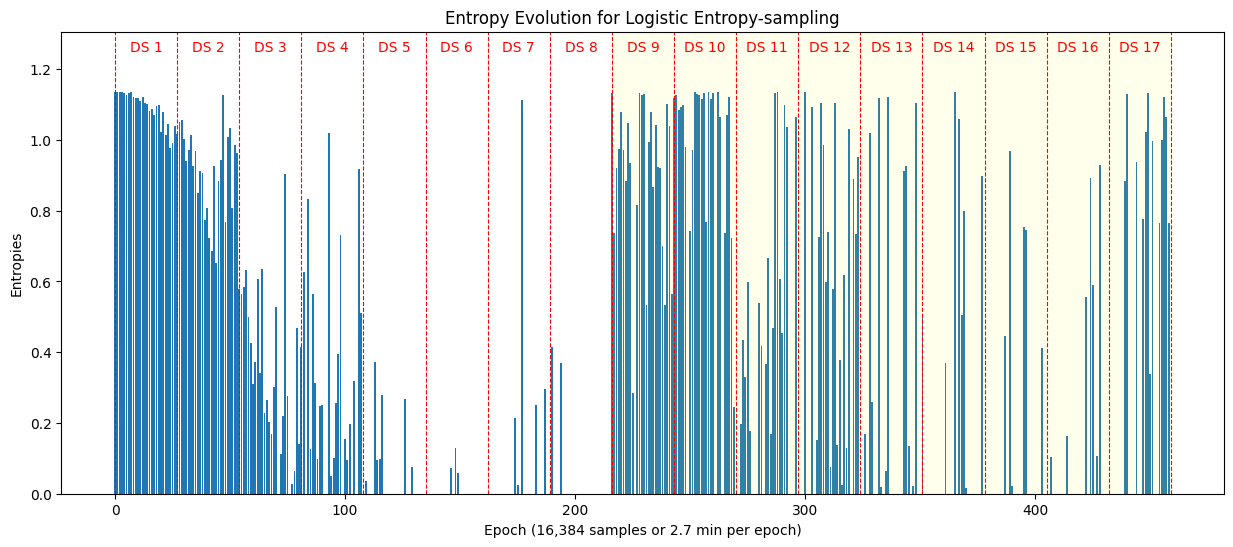

In [156]:
## plot the anomalies
sns.reset_defaults()
sns.reset_orig()
plt.figure(figsize=(15, 6))

nbr_epochs = X_train_top_f.shape[0]
entropies_reshaped = np.array(entropies).reshape(-1, 1)

# plot dashed line separators for the damage classes
for i in range(0, nbr_epochs+1, 27):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

# scale the entropies and plot them 
sc = StandardScaler()
obs = np.arange(len(entropies))
std_entropies = sc.fit_transform(entropies_reshaped).flatten()
plt.bar(obs, std_entropies)
plt.ylim(0, 1.15*max(std_entropies))

# color the damage states
plt.axvspan(27*8, 27*17, color='yellow', alpha=0.08)
plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
plt.ylabel('Entropies')
plt.title(f'Entropy Evolution for Logistic Entropy-sampling')

# add texts with DS 1, DS 2, etc.
text_pos = [i+13.5 for i in range(0, nbr_epochs, 27)]
for idx, pos in enumerate(text_pos):
    plt.text(pos, max(std_entropies)*1.1, f'DS {idx+1}', ha='center', color='red')

plt.show()

In [306]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=42).fit(X_train_top_f)
balanced_accuracy_score(y_test, gm.predict(X_test_top_f))

0.7939814814814814

### Method 2: Changepoint detection using Gaussian scoring

In [347]:
def gaussian_scorer_multi(y_values, window_size = 25, grace_period = 10, method = 0, plot = True):
    """
    Method: 0 if min of Gaussian anomaly scores for each variable, 1 if max of Gaussian anomaly scores, and 2 if product of scores, 3 if median of scores
    """
    global X_train_top_f
    from functools import reduce
    # initialize Gaussian anomaly detectors for eachb
    num_vals = y_values.shape[1]
    detectors = [anomaly.GaussianScorer(window_size=window_size, grace_period=grace_period) for el in range(num_vals)]
    anomaly_scores = [[0] for el in range(num_vals)]  

    # learn on one instance, score on the next
    for idx, detector in enumerate(detectors):
        for obs_idx, y in enumerate(y_values[:-1, idx]):
            detector = detector.learn_one(None, y) 
            anomaly_scores[idx].append(detector.score_one(None, y_values[obs_idx+1, idx]))
    
    # calculate the reductions (0 for minimum, 1 for maximum, 2 for product, else median)
    anomaly_scores_np = [np.array(el) for el in anomaly_scores]
    result = np.minimum.reduce(anomaly_scores_np) if method == 0 else \
         np.maximum.reduce(anomaly_scores_np) if method == 1 else reduce(np.multiply, anomaly_scores_np) if method == 2 else np.median(np.vstack(anomaly_scores_np), axis=0)
    mnmx = StandardScaler()
    obs = np.arange(len(result))
    normalized_result = mnmx.fit_transform(result.reshape(-1, 1)).flatten()
    
    # plot the anomalies
    if plot:
        import matplotlib.pyplot as plt
        # reset seaborn
        sns.reset_defaults()
        sns.reset_orig()
        plt.figure(figsize=(15, 6))

        # plot dashed line separators for each damage state
        nbr_epochs = X_train_top_f.shape[0]
        for i in range(0, nbr_epochs+1, 27):
            plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)
        
        # plot the anomaly scores
        plt.bar(obs, normalized_result)
        plt.ylim(0, 1.15*max(normalized_result))
        
        # color the damage state
        plt.axvspan(27*8, 27*17, color='yellow', alpha=0.08)

        # set up labels and text header for each damage scenario/segment
        string_method = "min_i" if method == 0 else "max_i" if method == 1 else "\prod_i" if method == 2 else "med_i"
        plt.xlabel('Epoch (16,384 samples or 2.7 min per observation)')
        plt.ylabel('(Standardized) Gaussian anomaly score')
        plt.title(rf'Gaussian Anomaly Window: $anomaly = 2\ {string_method} \|CDF(x_i) - 0.5\|$')
        
        # damage state header
        text_pos = [i+13.5 for i in range(0, nbr_epochs, 27)]
        for idx, pos in enumerate(text_pos):
            plt.text(pos, max(normalized_result)*1.1, f'DS {idx+1}', ha='center', color='red')

        plt.show()
    return result, normalized_result

In [187]:
def plot_distribution(data, title, window = None, threshold = None, damage_zone = None):    
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    
    if window is not None:
        data = data[np.logical_and(data >= window[0], data <= window[1])]
    
    if threshold is not None and damage_zone is None:
        below_threshold = data[data < threshold]
        above_threshold = data[data >= threshold]
        sns.histplot(below_threshold, bins='auto', color='#86bf91', edgecolor='black', label='Below Threshold')
        sns.histplot(above_threshold, bins='auto', color='cyan', edgecolor='black', label='Above Threshold')
        plt.legend()
    elif threshold is not None and damage_zone is not None:
        below_threshold = data[data < threshold]
        above_threshold_idx = np.where(data >= threshold)[0]
        print(above_threshold_idx)
        above_threshold_damage = [data[idx] for idx in above_threshold_idx if damage_zone(idx)]
        above_threshold_nodam = [data[idx] for idx in above_threshold_idx if not damage_zone(idx)]
        sns.histplot(below_threshold, bins='auto', color='#86bf91', edgecolor='black', label='Below Threshold')
        sns.histplot(above_threshold_nodam, bins='auto', color='cyan', edgecolor='black', label='Above Threshold (Undamaged)')
        sns.histplot(above_threshold_damage, bins='auto', alpha = 0.6, color='red', edgecolor='black', label='Above Threshold (Damaged)')
        print(f"{len(below_threshold)} are below threshold, {len(above_threshold_damage)} are above threshold with damaged, and {len(above_threshold_nodam)} are above threshold undamaged")
        plt.legend()
    else:
        sns.histplot(data, bins='auto', color='#86bf91', edgecolor='black')

    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('Standardized anomaly score', fontsize=14, labelpad=15)
    plt.ylabel('Frequency', fontsize=14, labelpad=15)
    plt.tight_layout()
    plt.show()
    
    sns.reset_defaults()
    sns.reset_orig()

In [358]:
def stacked_bar_plot(X, labels, title, width = 10):
    # Creating the DataFrame for seaborn
    label_names = {0: "Healthy", 1: "Damaged"}
    df = pd.DataFrame({'X': X, 'Labels': labels})
    df['Labels'] = df['Labels'].map(label_names)
    # Plotting using seaborn
    plt.figure(figsize=(width, 6))
    label_colors = {"Healthy": "cyan", "Damaged": "red"}
    ax = sns.histplot(data=df, x='X', hue='Labels', bins=12, multiple='stack', palette=label_colors)

    # Get the patches (rectangles) of the histogram
    patches = ax.patches
    bin_counts = len(patches) // 2  # assuming two labels (0 and 1)

    # Calculate the total counts in each bin
    total_counts = [patches[i].get_height() + patches[i + bin_counts].get_height() for i in range(bin_counts)]

    # Annotate each bin with the percentage of blue
    for i in range(bin_counts):
        blue_height = patches[i].get_height()
        percentage_blue = (blue_height / total_counts[i]) * 100 if total_counts[i] != 0 else 0
        ax.text(patches[i].get_x() + patches[i].get_width() / 2, total_counts[i], f'{percentage_blue:.1f}%', ha='center', va='bottom')

    plt.title(title)
    plt.xlabel('Standardized anomaly score')
    plt.ylabel('Frequency')
    plt.show()

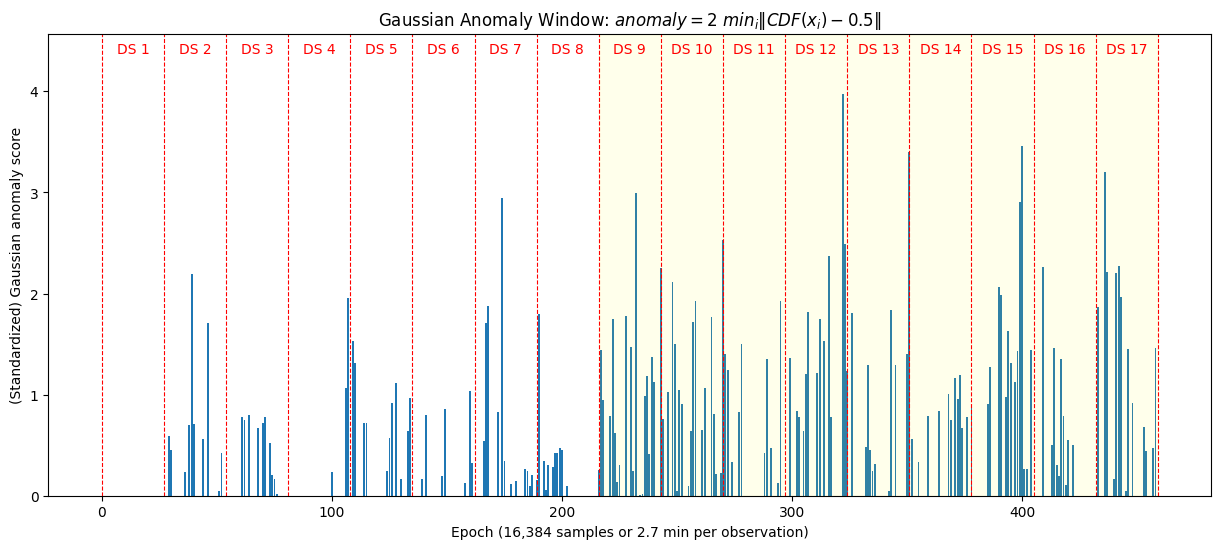

In [348]:
result, n_res = gaussian_scorer_multi(X_train_top_f, window_size = 25, grace_period = 20)

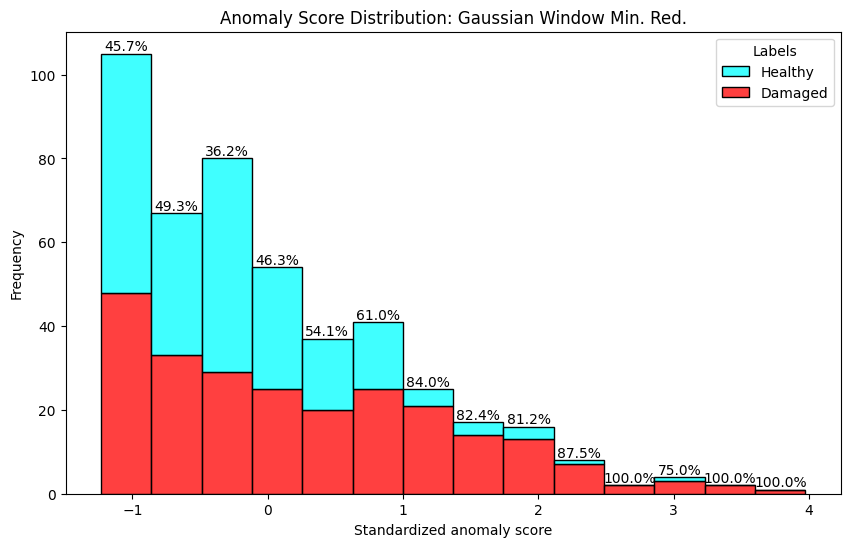

In [349]:
stacked_bar_plot(n_res, y_train, "Anomaly Score Distribution: Gaussian Window Min. Red.")

In [350]:
np.where(y_train == 1)[0][0:20], \
np.argmax(result), np.sum(y_train[np.where(n_res > 1)[0]])/len(y_train[np.where(n_res > 1)[0]]), np.sum(y_train[np.where(n_res > 2)[0]])/len(y_train[np.where(n_res > 2)[0]])

(array([216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
        229, 230, 231, 232, 233, 234, 235], dtype=int64),
 322,
 0.84,
 0.8888888888888888)

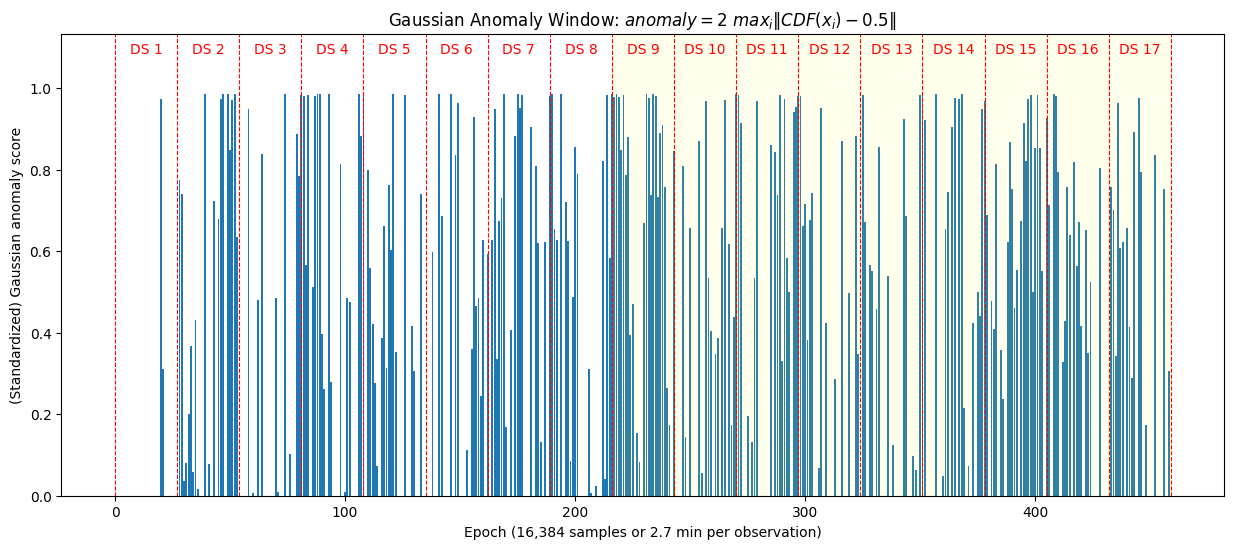

In [351]:
result, n_res = gaussian_scorer_multi(X_train_top_f, window_size = 25, grace_period = 20, method = 1) # max this time. REMARK: graph is very noisy. Taking a max is not a great idea

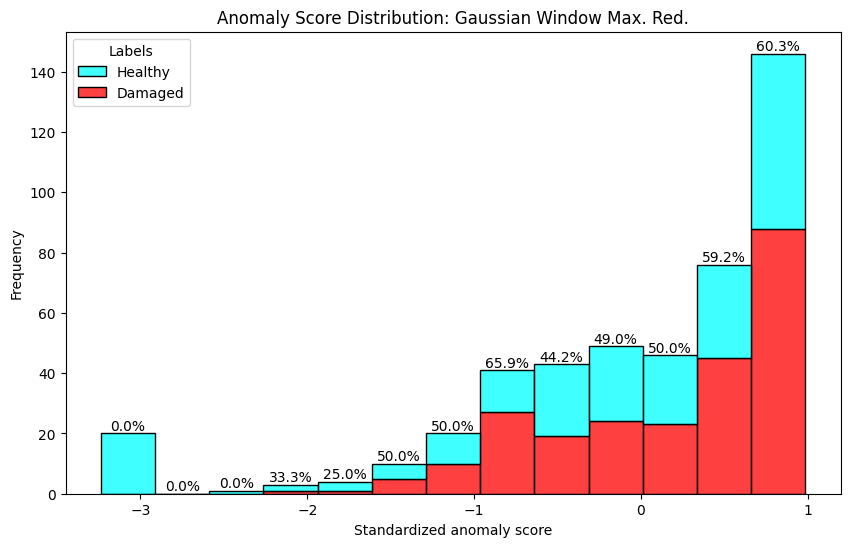

In [352]:
stacked_bar_plot(n_res, y_train, "Anomaly Score Distribution: Gaussian Window Max. Red.") # does not make any sense

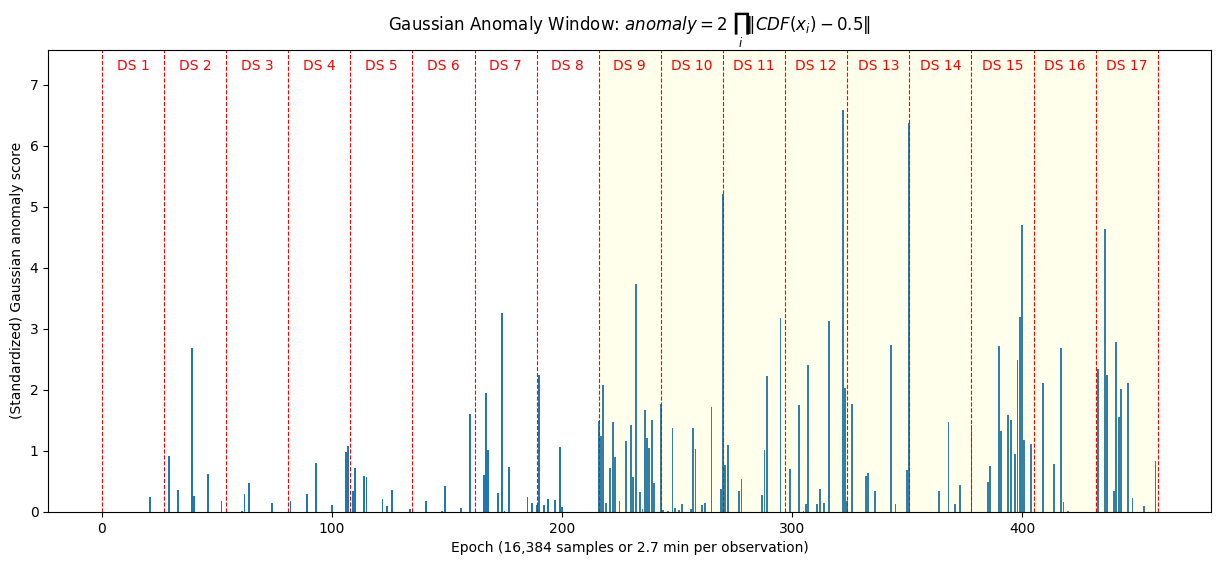

In [359]:
result, n_res = gaussian_scorer_multi(X_train_top_f, window_size =25, grace_period = 20, method = 2) # product this time

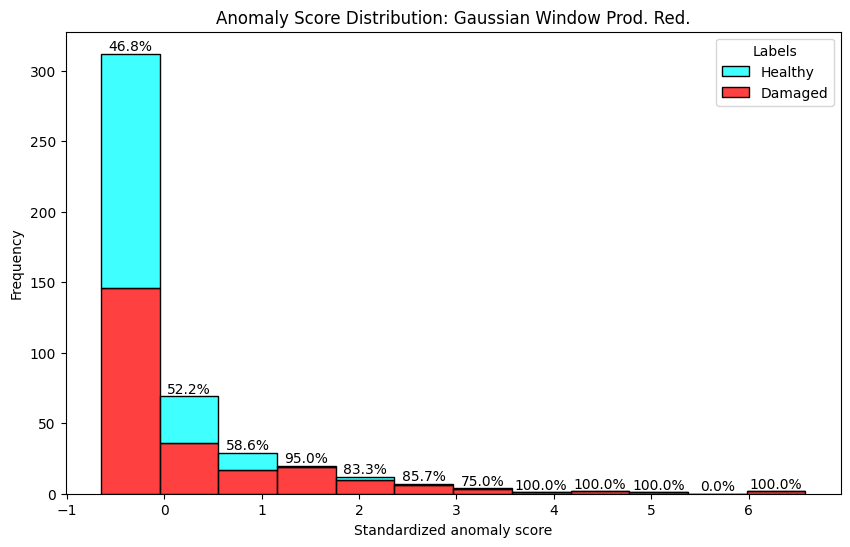

In [360]:
stacked_bar_plot(n_res, y_train, "Anomaly Score Distribution: Gaussian Window Prod. Red.", width=10) 

In [346]:
np.sum(y_train[np.where(n_res > 1)[0]])/len(y_train[np.where(n_res > 1)[0]]), np.sum(y_train[np.where(n_res > 2)[0]])/len(y_train[np.where(n_res > 2)[0]]) 

(0.4528301886792453, 0.5652173913043478)

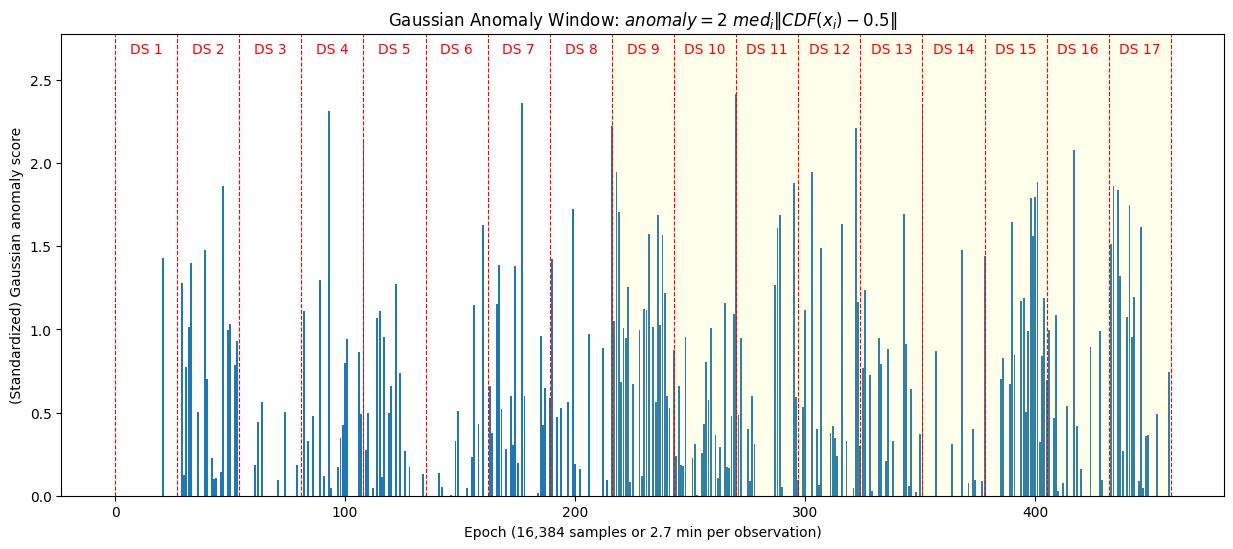

In [330]:
result, n_res = gaussian_scorer_multi(X_train_top_f, window_size = 25, grace_period = 20, method = 3) # median this time

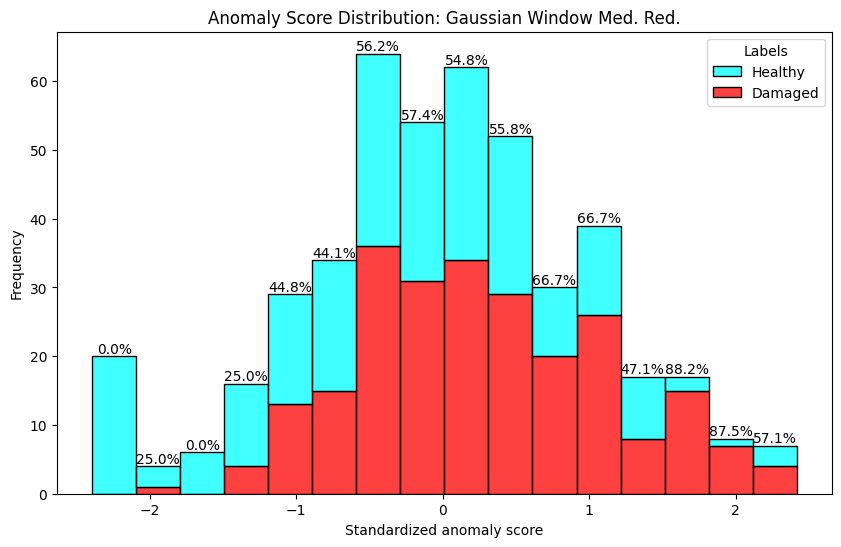

In [331]:
stacked_bar_plot(n_res, y_train, "Anomaly Score Distribution: Gaussian Window Med. Red.") 

In [332]:
np.where(y_train == 1)[0][0:20], \
np.max(result), np.argmax(result), np.sum(y_train[np.where(n_res > 1)[0]])/len(y_train[np.where(n_res > 1)[0]]), np.sum(y_train[np.where(n_res > 2)[0]])/len(y_train[np.where(n_res > 2)[0]]) 

(array([216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
        229, 230, 231, 232, 233, 234, 235], dtype=int64),
 0.9940197188818752,
 270,
 0.6986301369863014,
 0.625)

In [24]:
# turn these methods into AL algorithms
class AL:
    def __init__(self, anomaly_scores, query_count, labels_after_chgpt, warm_start = False):
        self.anomaly_scores = anomaly_scores
        self.labels_after_chgpt = labels_after_chgpt # how many samples to query after changepoint
        self.warm_start = warm_start
    def query(self):
        self.sample_points = np.argsort(self.anomaly_scores)
        self.sample_points = np.where(self.anomaly_scores >= self.threshold)[0]
        return self.sample_points # these are only start points of sampling
    def get_label_points(self): # indices of samples to label
        self.query()
        querying_points = []
        # avoid sampling across boundaries 
        def boundary(num):
            bin = num // 32
            return 32*(bin+1) - 1
        [[querying_points.append(min(num+i, boundary(num))) for i in range(self.labels_after_chgpt)] for num in self.sample_points]
        # warm start, comment the next line to avoid warm start
        if self.warm_start:
            querying_points = querying_points + list(range(10))
        res = list(set(querying_points))
        res.sort()
        return res

In [30]:
def ad_to_al_modified(normalized_res, warm_st):
    test_accuracies = []
    true_y = []
    pred_y = []
    pred_proba_y = []
    budget = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
    indices_ordered = np.argsort(normalized_res)[::-1]
    for i in budget:
        # get subset of data
        indices = indices_ordered[:i] if warm_st == False else np.hstack((indices_ordered[:i], np.arange(10)))
        train_data = X_train_top_feats[indices, :]
        train_labels = y_train[indices]
        
        # train the model
        log_reg = LogisticRegression(C=0.5) 
        log_reg.fit(train_data, train_labels)
        y_pred = log_reg.predict(X_test_top_f)
        pred_proba_y_temp = log_reg.predict_proba(X_test_top_f)[:, 1]
        if len(indices) == 50:
            true_y = y_test
            pred_y = y_pred
            pred_proba_y = pred_proba_y_temp
        # accuracy
        accuracy = accuracy_score(y_test, y_pred)
        test_accuracies.append(accuracy)

    return test_accuracies, true_y, pred_y, pred_proba_y

In [32]:
_, n_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20, method = 0, plot=False) # min this time
test_acc_min_gaus, true_y_min, pred_y_min, pred_proba_y = ad_to_al_modified(n_res, warm_st=True)
_, n_res_1 = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20, method = 3, plot=False) # median this time
test_acc_med_gaus, _, _, _ = ad_to_al_modified(n_res_1, warm_st=True)
_, n_res_2 = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20, method = 2, plot=False) # prod this time
test_acc_prod_gaus, _, _, _ = ad_to_al_modified(n_res_2, warm_st=True)

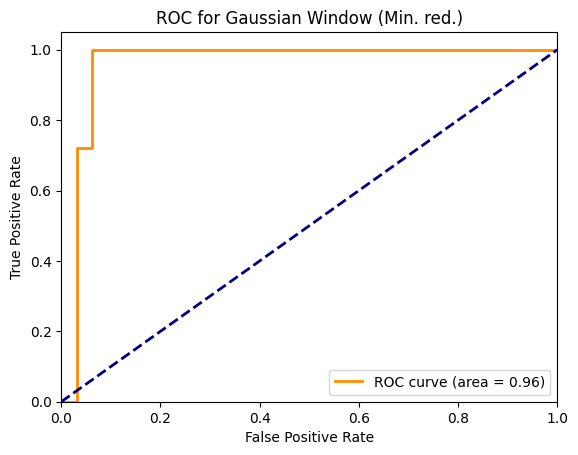

In [35]:
plot_roc(true_y_min, pred_proba_y, "Gaussian Window (Min. red.)")

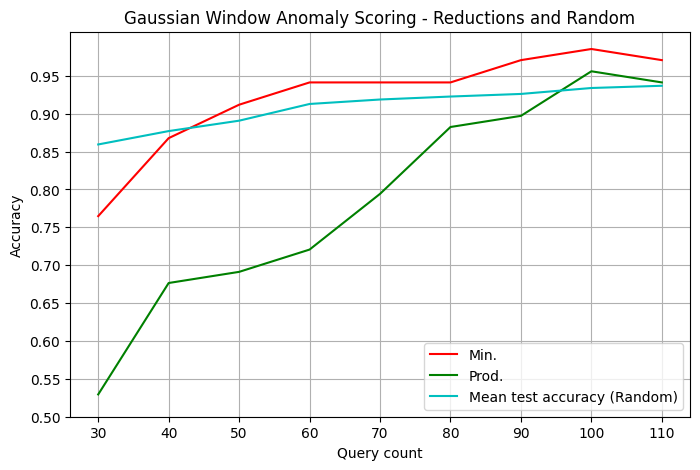

In [44]:
plt.figure(figsize=(8, 5))
x =  np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])+10 # add 10 since we do a warm start
low_cutoff = 20
upper_cutoff = 110

# apply lower and upper cutoffs for x
in_range = (x > low_cutoff) & (x <= upper_cutoff)

plt.plot(x[in_range], np.array(test_acc_min_gaus)[in_range], '-r', label='Min.')
#plt.plot(x[in_range], np.array(test_acc_med_gaus)[in_range], '-b', label='Med.')
plt.plot(x[in_range], np.array(test_acc_prod_gaus)[in_range], '-g', label='Prod.')

r_int = np.array(interpolation_range_samples)[0:100]
plt.plot(x[in_range], interp_with_extrapolation(x[in_range], r_int, np.array(y_test_rnd_mean)[0:100] / 100), '-c', label='Mean test accuracy (Random)')

plt.title("Gaussian Window Anomaly Scoring - Reductions and Random")
plt.xlabel("Query count")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xticks(np.arange(low_cutoff+10, upper_cutoff+10, 10)) 
plt.grid(True)
plt.legend()
plt.show()

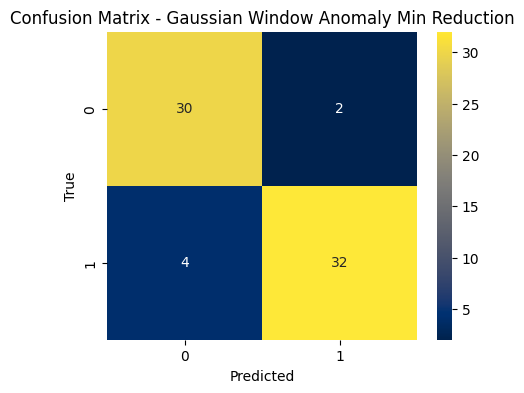

In [181]:
modes_pred = pred_y_min
modes_true = true_y_min
cm = confusion_matrix(modes_true, modes_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Gaussian Window Anomaly Min Reduction")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Method 3: ARIMA

In [36]:
import numpy as np
import arimafd as oa
import sys
from io import StringIO
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
from preprocess import get_avt_files, get_dataframes, preprocess_without_std

In [37]:
# get the acceleration signals
avt_files = get_avt_files("C:\\Users\\amroa\\Documents\\thesis\\data")
dfs_acc = get_dataframes(avt_files)
dfs_acc = pd.concat(dfs_acc, axis=0)
dfs_acc.reset_index(drop=True, inplace=True)
dfs_acc = dfs_acc.apply(lambda x: preprocess_without_std(x), axis=0) 
dfs_acc.shape

(10027008, 5)

In [ ]:
batch_size = 16384 # try with half of this also
nbr_samples = dfs_acc.shape[0]
change_points = []
windows = int(nbr_samples/batch_size) #  nbr of windows
anomalies= []

for i in range(windows):
    print(f"--- iter {i} ---")
    arima = oa.Arima_anomaly_detection(ar_order=4)
    window_1 = dfs_acc[i*batch_size:(i+1)*batch_size]
    window_2 = dfs_acc[(i+1)*batch_size:(i+2)*batch_size]
    arima.fit(window_1, window = int(batch_size//2), window_insensitivity = batch_size - 1)
    ts_anomaly = arima.predict(window_2, window = int(batch_size//2), window_insensitivity= batch_size - 1)
    np.save(f"arima_{i}.npy", ts_anomaly.to_numpy())

In [39]:
# extract the relevant file indices for training and testing separately
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 612/17 = 36, where 612 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices = np.append(test_indices, i*nbr_splits + np.array(random.sample(range(nbr_splits), test_split)))
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices]))

print(len(train_indices))

544


In [40]:
def plot_anomalies(title, path):
    # first window always healthy
    perc_ones = [0] # percent of ones in each window
    nbr_epochs = 544
    tot_epochs = 611
    for i in range(tot_epochs):
        if i in train_indices:
            cur_window = np.load(f"{path}/arima_{i}.npy")
            position_ones = np.where(cur_window == 1)[0]
            perc_ones.append(len(position_ones)/batch_size)

    scaler = StandardScaler()
    counts = scaler.fit_transform(np.array(perc_ones).reshape(-1, 1)).flatten()

    plt.figure(figsize=(15, 6)) 
    print(len(counts), np.where(counts > 3.5)[0])
    plt.bar(range(len(counts)), counts)
    plt.xlabel('Epoch (2.7 min ~ 16,384 samples)')
    plt.ylabel('(Standardized) percent of anomalies per epoch')
    plt.axvspan(32*8, 32*17, color='yellow', alpha=0.08)
    plt.ylim(0, 1.15*max(counts))
    plt.title(title)

    for i in range(0, nbr_epochs+1, int(nbr_epochs/17)):
        plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

    text_pos = [i+int(nbr_epochs/(2*17)) for i in range(0, nbr_epochs, int(nbr_epochs/17))]
    for idx, pos in enumerate(text_pos):
        plt.text(pos, max(counts)*0.9, f'DS {idx+1}', ha='center', color='red')

    plt.show()

    return counts

544 [ 30  65 149 188 238 244 250 488]


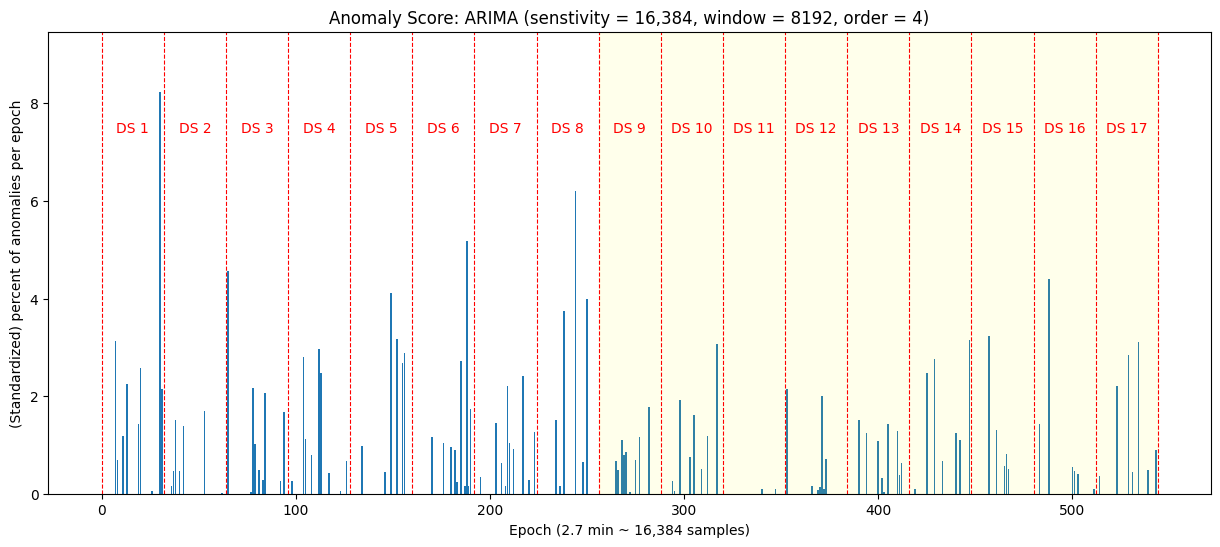

In [41]:
n_res = plot_anomalies("Anomaly Score: ARIMA (senstivity = 16,384, window = 8192, order = 4)", "./arima_16383_sens_8192_win")

544 [ 54 172 202 206 272 422]


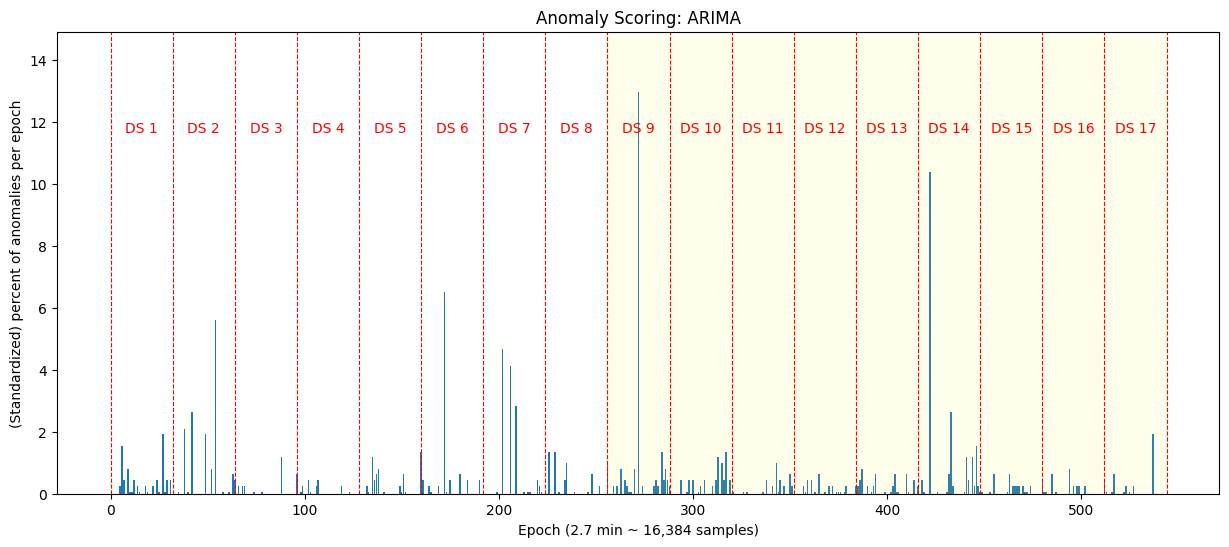

In [42]:
#n_res = plot_anomalies("Anomaly Scoring: ARIMA", "./arima_ar9_win8192_sens16383") 
n_res = plot_anomalies("Anomaly Scoring: ARIMA", "./arima_100_sens_100_win") 

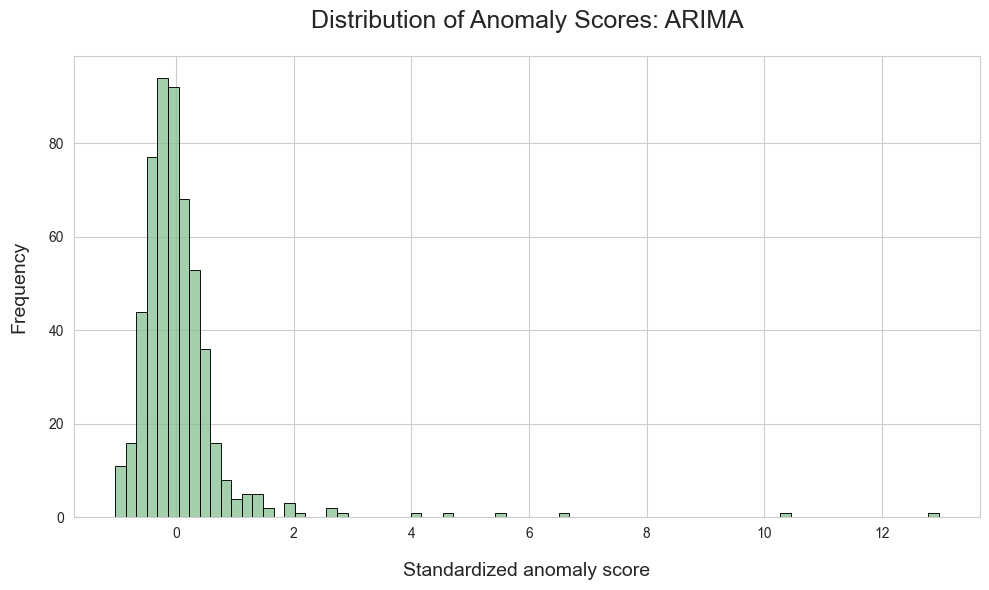

In [43]:
plot_distribution(n_res, "Distribution of Anomaly Scores: ARIMA")

In [280]:
# AL
test_accuracies, train_accuracies, samples_used = ad_to_al(n_res, warm_st=False)

12.971276124021484
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only

0.9558823529411765


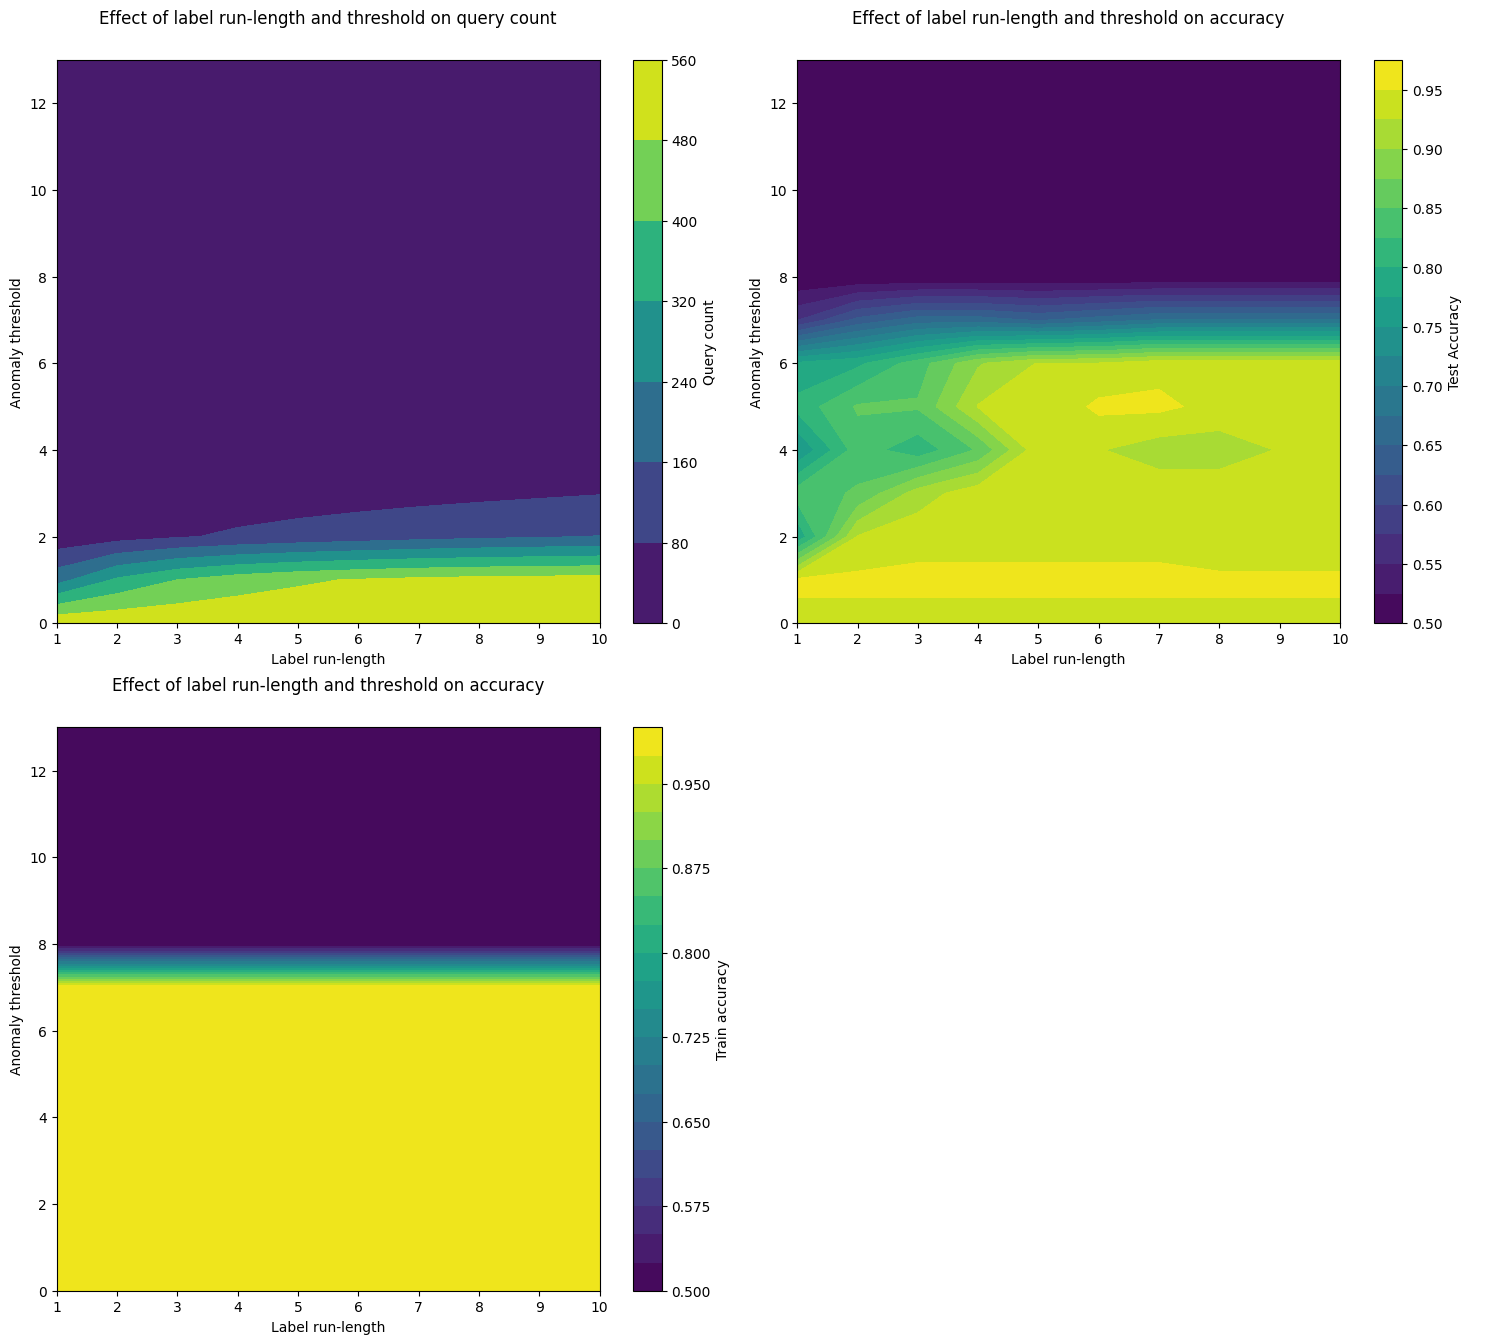

In [281]:
acc_train_matrix, acc_test_matrix, samples_matrix = plot_contour_al(train_accuracies, test_accuracies, samples_used)

[ 5 10 15 20 25 30 35 40 45 50]
[0.80882353 0.85294118 0.85294118 0.92647059 0.92647059 0.95588235
 0.95588235 0.94117647 0.94117647 0.94117647]
***
[ 4  8 12 16 20 24 28 32 36 40]
[0.77941176 0.79411765 0.83823529 0.89705882 0.92647059 0.92647059
 0.94117647 0.94117647 0.94117647 0.94117647]
***


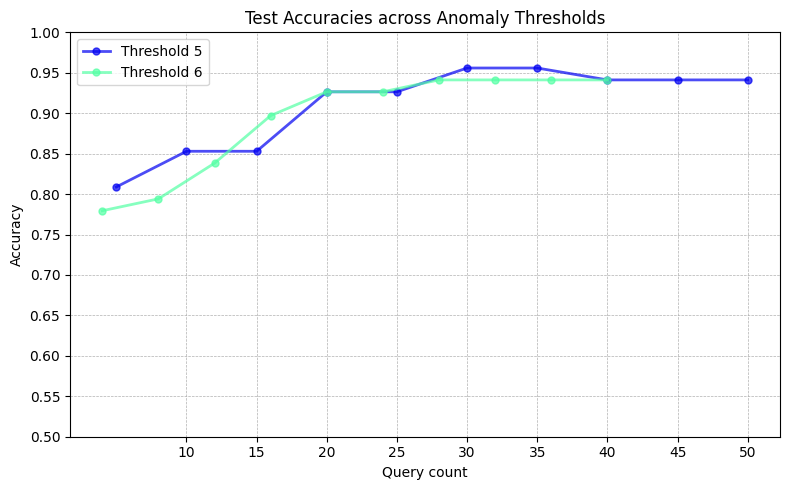

In [282]:
plot_accuracy_diff_thresholds([5, 6], acc_test_matrix, samples_matrix)

5.428673416592768
Above the threshold lies 0.007352941176470588 of the data and below it 0.9926470588235294 of the data
[ 54 172 272 422]
540 are below threshold, 2 are above threshold with damaged, and 2 are above threshold undamaged


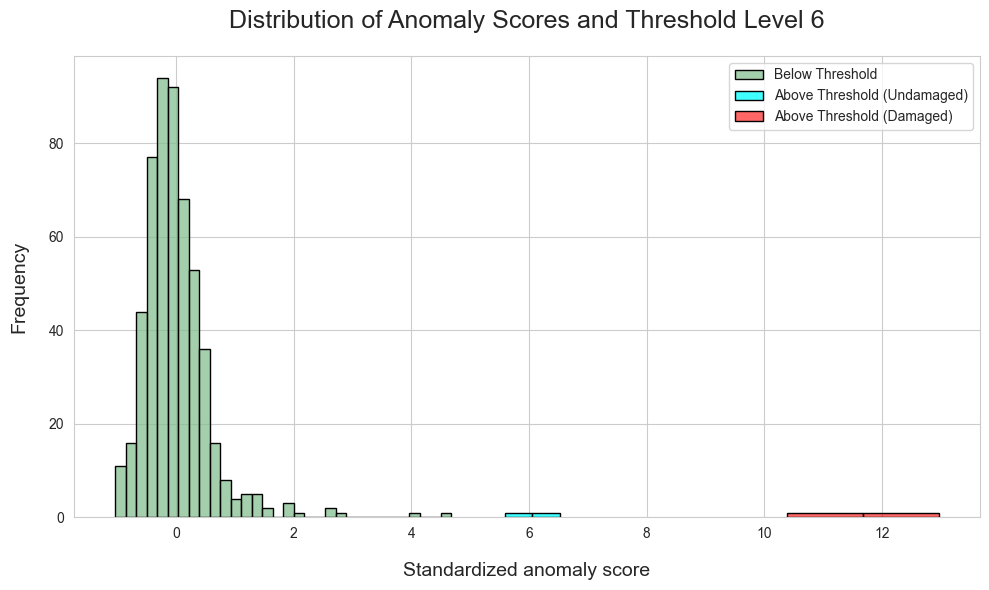

In [286]:
threshold_5 = np.linspace(min(n_res), max(n_res), 14)[6] 
print(threshold_5)
print(f"Above the threshold lies {np.sum(n_res > threshold_5)/len(n_res)} of the data and below it {1- np.sum(n_res > threshold_5)/len(n_res)}"  
      f" of the data")
plot_distribution(n_res, "Distribution of Anomaly Scores and Threshold Level 6", threshold=threshold_5, damage_zone=lambda x: x >= 256)

In [44]:
test_acc_arima, true_y_arima, pred_y_arima, pred_proba_y_arima = ad_to_al_modified(n_res, warm_st=True)

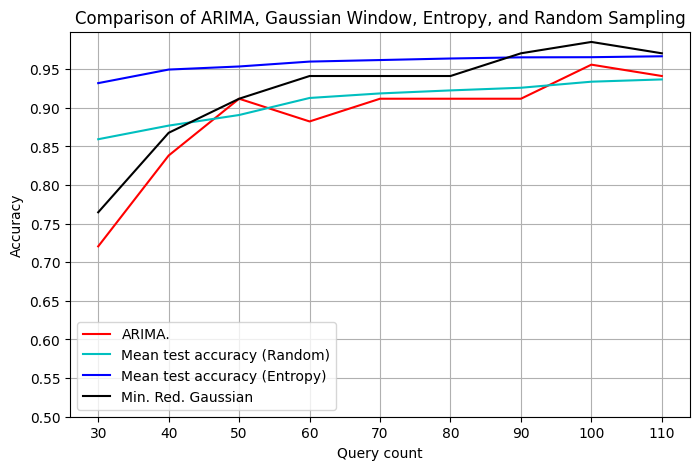

In [62]:
plt.figure(figsize=(8, 5))
x =  np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])+10 # add 10 since we do a warm start
low_cutoff = 20
upper_cutoff = 110

# apply lower and upper cutoffs for x
in_range = (x > low_cutoff) & (x <= upper_cutoff)

plt.plot(x[in_range], np.array(test_acc_arima)[in_range], '-r', label='ARIMA.')

r_int = np.array(interpolation_range_samples)[0:100]
plt.plot(x[in_range], interp_with_extrapolation(x[in_range], r_int, np.array(y_test_rnd_mean)[0:100] / 100), '-c', label='Mean test accuracy (Random)')
plt.plot(x[in_range], interp_with_extrapolation(x[in_range], r_int, np.array(y_test_mean)[0:100] / 100) , '-b', label='Mean test accuracy (Entropy)')

plt.plot(x[in_range], np.array(test_acc_min_gaus)[in_range], '-k', label='Min. Red. Gaussian')
#plt.plot(x[in_range], np.array(test_acc_med_gaus)[in_range], '-b', label='Med.')
#plt.plot(x[in_range], np.array(test_acc_prod_gaus)[in_range], '-g', label='Prod.')



plt.title("Comparison of ARIMA, Gaussian Window, Entropy, and Random Sampling")
plt.xlabel("Query count")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xticks(np.arange(low_cutoff+10, upper_cutoff+10, 10)) 
plt.grid(True)
plt.legend()
plt.show()

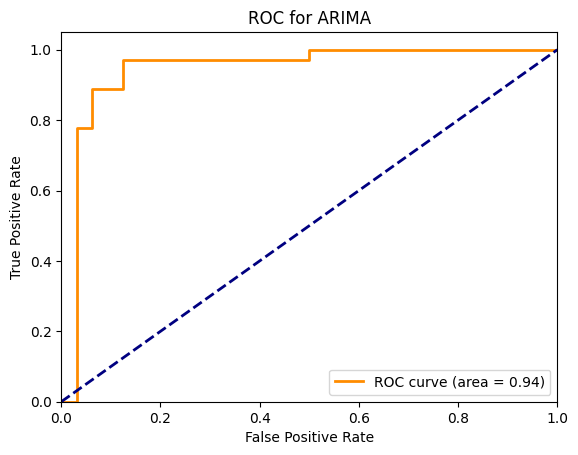

In [45]:
plot_roc(true_y_arima, pred_proba_y_arima, "ARIMA")

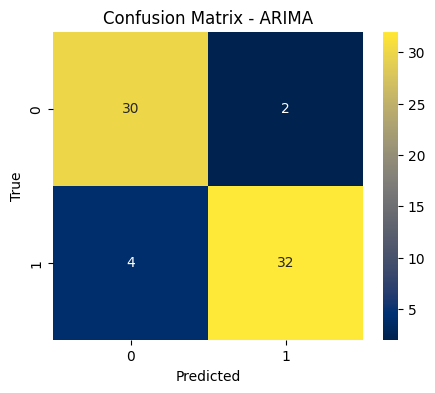

In [54]:
modes_pred = pred_y_arima
modes_true = true_y_arima
cm = confusion_matrix(modes_true, modes_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - ARIMA")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

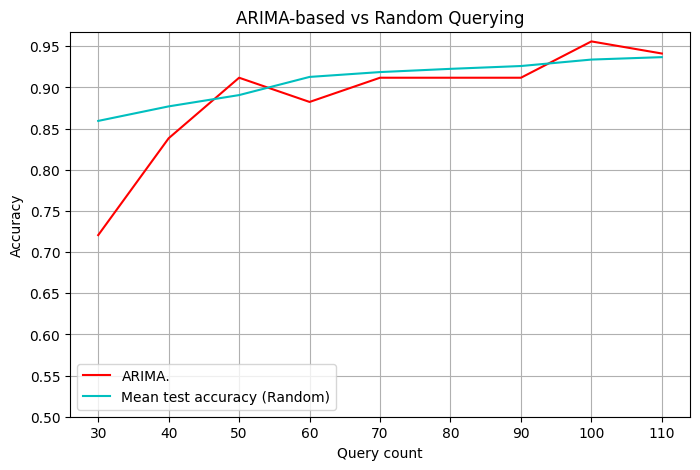

In [55]:
plt.figure(figsize=(8, 5))
x =  np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])+10 # add 10 since we do a warm start
low_cutoff = 20
upper_cutoff = 110

# apply lower and upper cutoffs for x
in_range = (x > low_cutoff) & (x <= upper_cutoff)

plt.plot(x[in_range], np.array(test_acc_arima)[in_range], '-r', label='ARIMA.')

r_int = np.array(interpolation_range_samples)[0:100]
plt.plot(x[in_range], interp_with_extrapolation(x[in_range], r_int, np.array(y_test_rnd_mean)[0:100] / 100), '-c', label='Mean test accuracy (Random)')

plt.title("ARIMA-based vs Random Querying")
plt.xlabel("Query count")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xticks(np.arange(low_cutoff+10, upper_cutoff+10, 10)) 
plt.grid(True)
plt.legend()
plt.show()

### Method 4: Concept drift 

In [63]:
from river import drift

In [64]:
X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in X_train_top_feats
        ]
y_train = binarize(labels_train)
y_river_train = y_train.tolist()  
min_dif = 1000
for w in [10, 15, 20, 25, 30, 35, 40, 45]:
    for s in [5, 10, 15, 20, 25, 30, 35, 40]:
        if s >= w - 20:
            continue
        # Combine X_river and y_river_train into a single dataset
        dataset = zip(X_river, y_river_train)
        adwin = drift.KSWIN(alpha=0.009, window_size = w, stat_size=s, seed=42)
        changes = []
        i = 0
        for x, y in dataset:
            val = sum(abs(value) for value in x.values())
            _ = adwin.update(val)
            i += 1
            if adwin.drift_detected:
                changes.append(i)
                print(f"Change detected at index {i}, input value: {val}")
        
        chg_np = np.array(changes)
        chg_np = chg_np[chg_np > 255]
        if len(chg_np) > 0:
            diff = chg_np[0] - 256
            if diff < min_dif:
                print(f"min df at {w} and {s} is {diff}")
                min_dif = diff


Change detected at index 116, input value: 72.23265990116718
Change detected at index 172, input value: 66.40940858425311
Change detected at index 261, input value: 50.465364126402356
Change detected at index 301, input value: 42.08723060362949
Change detected at index 357, input value: 45.720460871290605
Change detected at index 401, input value: 50.845635523702754
Change detected at index 466, input value: 62.39831160620128
Change detected at index 506, input value: 63.96193424103376
min df at 30 and 5 is 5
Change detected at index 61, input value: 54.1134578805316
Change detected at index 113, input value: 75.3066925969611
Change detected at index 197, input value: 47.74821812102632
Change detected at index 280, input value: 82.40460927083706
Change detected at index 323, input value: 54.37973023458515
Change detected at index 358, input value: 46.19147156703572
Change detected at index 412, input value: 64.20697443886225
Change detected at index 466, input value: 62.39831160620128


In [140]:
# Combine X_river and y_river_train into a single dataset
dataset = zip(X_river, y_river_train)
adwin = drift.KSWIN(alpha=0.0001, window_size = 125, stat_size=30, seed=42)
changes = []
i = 0
for x, y in dataset:
    val = sum(value for value in x.values())
    _ = adwin.update(val)
    i += 1
    if adwin.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

print([i*32 for i in range(17)])
print(len(changes))

Change detected at index 135, input value: -34.002021036067816
Change detected at index 268, input value: 15.541553644695881
Change detected at index 541, input value: 4.514618939811724
[0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512]
3


Change detected at index 68, input value: 50.63908196865761
Change detected at index 118, input value: 63.618583406232986
Change detected at index 172, input value: 66.40940858425311
Change detected at index 222, input value: 50.92647454181557
Change detected at index 284, input value: 81.41833029049897
Change detected at index 361, input value: 49.69949143964021
Change detected at index 468, input value: 55.156441980875606
Change detected at index 522, input value: 44.317889825505745


In [170]:
X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in X_train_top_feats
        ]
y_train = binarize(labels_train)
y_river_train = y_train.tolist()  

# Combine X_river and y_river_train into a single dataset
dataset = zip(X_river, y_river_train)
i = -1
ph = drift.PageHinkley(min_instances=50)
for x, y in dataset:
    mean_x = sum(abs(value)*abs(value) for value in x.values())
    #mean_x = sum(x.values())
    i = i + 1
    _ = ph.update(mean_x)
    if ph.drift_detected:
        print(f"Change detected at index {i}, input value: {mean_x}")

Change detected at index 49, input value: 84.61459307923143
Change detected at index 99, input value: 39.653615335784025
Change detected at index 149, input value: 57.36089482813027
Change detected at index 199, input value: 155.07580214175766
Change detected at index 249, input value: 29.668402553231264
Change detected at index 299, input value: 36.37915235648901
Change detected at index 349, input value: 148.7775413166851
Change detected at index 399, input value: 47.22800817550402
Change detected at index 449, input value: 63.973142071300956
Change detected at index 499, input value: 82.73078140542225


In [128]:
X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in X_train_top_feats
        ]
y_train = binarize(labels_train)
y_river_train = y_train.tolist()  

# Combine X_river and y_river_train into a single dataset
dataset = zip(X_river, y_river_train)
i = -1
ph = drift.PageHinkley()
drifts = 0
for x, y in dataset:
    #mean_x = sum(abs(value) for value in x.values())
    mean_x = sum(x.values())
    i = i + 1
    _ = ph.update(mean_x)
    if ph.drift_detected:
        drifts+=1
        print(f"Change detected at index {i}, input value: {mean_x}")

Change detected at index 29, input value: -18.46407083964303
Change detected at index 59, input value: -11.804376312270366
Change detected at index 89, input value: 5.328830571662262
Change detected at index 119, input value: -25.94326271511791
Change detected at index 149, input value: -29.663347797391737
Change detected at index 179, input value: -33.33678865446554
Change detected at index 209, input value: -3.8699999787781683
Change detected at index 239, input value: -20.224052766570832
Change detected at index 269, input value: 11.265983384956582
Change detected at index 299, input value: 18.569451733040964
Change detected at index 334, input value: 52.935287361849
Change detected at index 364, input value: 33.21529361764239
Change detected at index 394, input value: 10.993514283209848
Change detected at index 424, input value: 21.699549215057388
Change detected at index 454, input value: 28.795717003214477
Change detected at index 484, input value: 23.525887825062437
Change detec

#### Supplementary: Example usage of RiverML on iris from Sklearn

In [79]:
"""
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics

# Load the iris dataset from sklearn
iris_sk = skdatasets.load_iris()

# Prepare the data in a format compatible with river
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in iris_sk['data']
]
y_river = iris_sk['target'].tolist()  # Converting to list for easier iteration

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression()
model = active.EntropySampler(base_model, seed=42)

n_samples_used = 0

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_one(x)  # x is now a dictionary
    metric = metric.update(y_true, y_pred)

    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

print(metric)
print(f"Number of samples used for learning: {n_samples_used}")
"""

'\nfrom sklearn import datasets as skdatasets  # Import to avoid naming conflicts\nfrom river import active\nfrom river import datasets\nfrom river import linear_model\nfrom river import metrics\n\n# Load the iris dataset from sklearn\niris_sk = skdatasets.load_iris()\n\n# Prepare the data in a format compatible with river\nX_river = [\n    {f"feature_{i}": value for i, value in enumerate(sample)}\n    for sample in iris_sk[\'data\']\n]\ny_river = iris_sk[\'target\'].tolist()  # Converting to list for easier iteration\n\nmetric = metrics.Accuracy()\nbase_model = linear_model.LogisticRegression()\nmodel = active.EntropySampler(base_model, seed=42)\n\nn_samples_used = 0\n\n# Process each sample in the dataset\nfor i in range(len(X_river)):\n    x = X_river[i]\n    y_true = y_river[i]\n    y_pred, ask = model.predict_one(x)  # x is now a dictionary\n    metric = metric.update(y_true, y_pred)\n\n    if ask:\n        n_samples_used += 1\n        model = model.learn_one(x, y_true)  # Learn f